In [7]:

from torchvision.datasets import MNIST 
from torchvision import transforms 
from torch.utils.data import DataLoader,Dataset
import torch 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

from exp.nb_02 import * 


class Flatten(torch.nn.Module):
  def forward(self,img):
    img_shape = img.shape
    return img.view(img_shape[0],img_shape[1]*img_shape[2])

mnist_tnfs = transforms.Compose([transforms.ToTensor(),Flatten()])


x_train,y_train,x_valid,y_valid = get_data()




In [9]:
class MNISTDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [11]:
train = MNISTDataset(x_train,y_train)
test = MNISTDataset(x_valid,y_valid)

In [12]:

bs=128
train_dl = DataLoader(train,bs,shuffle=True, drop_last=True)
valid_dl = DataLoader(test,bs,shuffle=False)

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()


tensor(4)

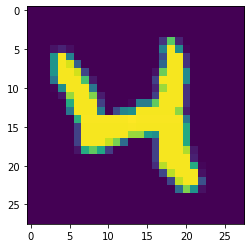

In [38]:
import matplotlib.pyplot as plt

plt.imshow(x_train[20].view(28,28))
y_train[20]

In [24]:

n,m = len(train),train[0][0].shape[0]
c = y_train.max()+1
nh = 10

lr = 0.01   # learning rate
epochs = 30 # how many epochs to train for
n,m,c,lr,epochs

class MNISTNN(torch.nn.Module):
  def __init__(self,m,nh,c):
    super(MNISTNN, self).__init__()
    self.lin1 = torch.nn.Linear(m,nh)
    self.act1 = torch.nn.ReLU()
    self.out = torch.nn.Linear(nh,10)
  
  def forward(self,xb):
    xb = xb.squeeze(1)
    return self.out(self.act1(self.lin1(xb)))

loss_func = F.cross_entropy


In [27]:

xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

model = MNISTNN(m,nh,c)

model.lin1.bias

model_layers = ['lin1','out']

loss_func(model(xb), yb)


tensor(20.7908, grad_fn=<NllLossBackward>)

In [31]:
model

MNISTNN(
  (lin1): Linear(in_features=784, out_features=10, bias=True)
  (act1): ReLU()
  (out): Linear(in_features=10, out_features=10, bias=True)
)

In [32]:


def fit(epochs, model, loss_func, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            with torch.no_grad():
                for layer_name in model_layers:
                    l = getattr(model,layer_name)
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()


        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv


In [33]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
model = MNISTNN(m,nh,c)
loss,acc = fit(5, model, loss_func, train_dl, valid_dl)


0 tensor(2.1166) tensor(0.1897)
1 tensor(2.1056) tensor(0.1942)
2 tensor(2.0658) tensor(0.2037)
3 tensor(2.0670) tensor(0.2039)
4 tensor(2.0435) tensor(0.2084)


In [34]:

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [35]:
model = MNISTNN(m,nh,c)
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)


0 tensor(2.1705) tensor(0.1579)
1 tensor(2.1260) tensor(0.1866)
2 tensor(2.1123) tensor(0.1906)
3 tensor(2.3215) tensor(0.1138)
4 tensor(2.3228) tensor(0.1140)


In [36]:
train